# <center>TMVA Classification Using BDT</center>

In this notebook we still classify di-Higgs new data with Boosted Decision Trees meethod.

In [1]:
import ROOT
from ROOT import TMVA, TTree


ROOT.TMVA.Tools.Instance()
## For PYMVA methods
TMVA.PyMethodBase.PyInitialize()

Welcome to JupyROOT 6.14/04


## Declare Factory and Input Data

#### Separate data from fakes

In [2]:
oldfile = ROOT.TFile("data.root")
oldtree = oldfile.Get("Nominal")
nentries = oldtree.GetEntries()

newfile = ROOT.TFile("small.root","recreate")
backgroundTreeB1 = oldtree.CloneTree(0)

for i in range(nentries):
    sample = oldtree.GetBranch('sample').GetEntry(i)
    if (sample == 6):
        backgroundTreeB1.Fill()
    
backgroundTreeB1.AutoSave()

13758

In [3]:
outputFile = ROOT.TFile.Open("Higgs_ClassificationOutput.root", "RECREATE")

# Factory
factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

# Input data
# We define now the input data file and we retrieve the ROOT TTree objects with the signal and background input events
inputFileS1 = ROOT.TFile.Open("Xtohh1000.root")
inputFileS2 = ROOT.TFile.Open("Xtohh2000.root")
inputFileB2 = ROOT.TFile.Open("stop.root")
inputFileB3 = ROOT.TFile.Open("ttbar.root")
inputFileB4 = ROOT.TFile.Open("W+jets.root")
inputFileB5 = ROOT.TFile.Open("Zee_221.root")
inputFileB6 = ROOT.TFile.Open("Ztautau_221.root")
inputFileB7 = ROOT.TFile.Open("ZZ_Pw.root")

# retrieve input trees
signalTree1     = inputFileS1.Get("Nominal")
signalTree2     = inputFileS2.Get("Nominal")
backgroundTreeB2 = inputFileB2.Get("Nominal")
backgroundTreeB3 = inputFileB3.Get("Nominal")
backgroundTreeB4 = inputFileB4.Get("Nominal")
backgroundTreeB5 = inputFileB5.Get("Nominal")
backgroundTreeB6 = inputFileB6.Get("Nominal")
backgroundTreeB7 = inputFileB7.Get("Nominal")

signalTree1.Print()

******************************************************************************
*Tree    :Nominal   : Nominal                                                *
*Entries :    23148 : Total =         2341482 bytes  File  Size =     894529 *
*        :          : Tree compression factor =   2.61                       *
******************************************************************************
*Br    0 :sample    : string                                                 *
*Entries :    23148 : Total  Size=     325841 bytes  File Size  =      36319 *
*Baskets :       14 : Basket Size=      32000 bytes  Compression=   8.96     *
*............................................................................*
*Br    1 :EventWeight : EventWeight/F                                        *
*Entries :    23148 : Total  Size=      93425 bytes  File Size  =      18889 *
*Baskets :        4 : Basket Size=      32000 bytes  Compression=   4.92     *
*...................................................

## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input data abd variables 

We add first the signal and background trees in the data loader and then we
define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

In [4]:
loader = ROOT.TMVA.DataLoader("dataset")

### global event weights per tree (see below for setting event-wise weights)
signalWeight     = 1.0
backgroundWeight = 1.0
   
### You can add an arbitrary number of signal or background trees
loader.AddSignalTree    ( signalTree1,     signalWeight     )
loader.AddSignalTree    ( signalTree2,     signalWeight     )
loader.AddBackgroundTree( backgroundTreeB1, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB2, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB3, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB4, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB5, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB6, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeB7, backgroundWeight )

## Define input variables 
for branch in signalTree1.GetListOfBranches():
    loader.AddVariable(branch.GetName())

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree Nominal of type Signal with 23148 events
                         : Add Tree Nominal of type Signal with 56188 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree Nominal of type Background with 101752 events
                         : Add Tree Nominal of type Background with 1096 events
                         : Add Tree Nominal of type Background with 5480 events
                         : Add Tree Nominal of type Background with 22618 events
                         : Add Tree Nominal of type Background with 14740 events
                         : Add Tree Nominal of type Background with 84726 events
                         : Add Tree Nominal of type Background with 634 events


There are:
- 79336 signal events
- 231046 background events

## Setup Dataset(s)

Setup the DataLoader by splitting events in training and test samples. 
Here we use a random split and a fixed number of training and test events.


In [5]:
## Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";


loader.PrepareTrainingAndTestTree(mycuts, mycutb,
                                  "nTrain_Signal=60000:nTrain_Background=60000:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )

## BDT

In [6]:
## Boosted Decision Trees
factory.BookMethod(loader,ROOT.TMVA.Types.kBDT, "BDT",
                   "!V:NTrees=2000:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:"
                   "BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20" )

<ROOT.TMVA::MethodBDT object ("BDT") at 0x65cc380>

Factory                  : Booking method: BDT
                         : 
DataSetFactory           : [dataset] : Number of events in input trees
                         : 
                         : 
                         : Number of training and testing events
                         : ---------------------------------------------------------------------------
                         : Signal     -- training events            : 60000
                         : Signal     -- testing events             : 19336
                         : Signal     -- training and testing events: 79336
                         : Background -- training events            : 60000
                         : Background -- testing events             : 171046
                         : Background -- training and testing events: 231046
                         : 
DataSetInfo              : Correlation matrix (Signal):
                         : -------------------------------------------------------------

## Train Methods

In [7]:
factory.TrainAllMethods()

Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'sample' <---> Output : variable 'sample'
                         : Input : variable 'EventWeight' <---> Output : variable 'EventWeight'
                         : Input : variable 'EventNumber' <---> Output : variable 'EventNumber'
                         : Input : variable 'm_region' <---> Output : variable 'm_region'
                         : Input : variable 'm_FJNbtagJets' <---> Output : variable 'm_FJNbtagJets'
                         : Input : variable 'm_FJpt' <---> Output : variable 'm_FJpt'
                         : Input : variable 'm_FJeta' <---> Output : variable 'm_FJeta'
                         : Input : variable 'm_FJphi' <---> Output : variable 'm_FJphi'
                         : Input : va

## Test  all methods

Here we test all methods using the test data set

In [8]:
factory.TestAllMethods()

Factory                  : Test all methods
Factory                  : Test method: BDT for Classification performance
                         : 
BDT                      : [dataset] : Evaluation of BDT on testing sample (190382 events)
                         : Elapsed time for evaluation of 190382 events: 20.2 sec       


## Evaluate all methods

Here we evaluate all methods and compare their performances, computing efficiencies, ROC curves etc.. using both training and tetsing data sets. Several histograms are produced which can be examined with the TMVAGui or directly using the output file

In [9]:
factory.EvaluateAllMethods()

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: BDT
                         : 
BDT                      : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
TFHandler_BDT            :      Variable             Mean             RMS     [        Min             Max ]
                         : ------------------------------------------------------------------------------------
                         :        sample:     1.0634e+08     4.8387e+06   [     1.0410e+08     1.3786e+08 ]
                         :   EventWeight:      0.0050198       0.022820   [        -1.2210         1.2020 ]
                         :   EventNumber:     2.5773e+06     9.3769e+06   [         0.0000     1.3499e+08 ]
                         :      m_region:     1.1429e+08     1.7576e+07   [     1.0659e+08     1.7644e+08 ]
                         : m_FJNbtagJets:        0.21428        0.51959   [       

## Plot ROC Curve
We enable JavaScript visualisation for the plots

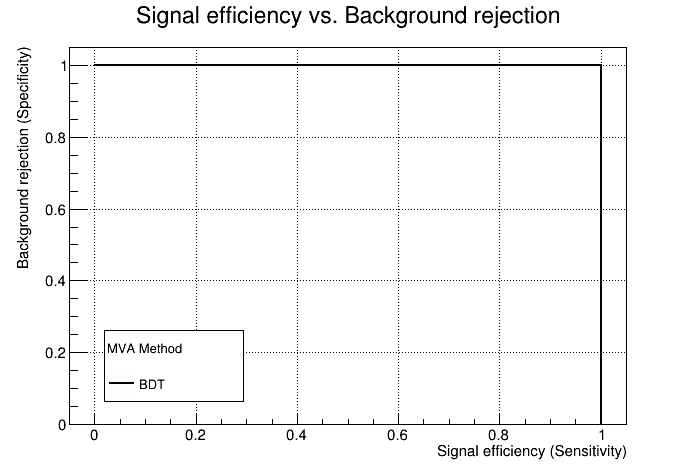

In [10]:
c1 = factory.GetROCCurve(loader)
c1.Draw()